In [1]:
import sys
sys.path.append('..')
from scripts.data_analysis import DataAnalysis
from scripts.preprocess import Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import t, pearsonr
import xgboost as xg
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import pandas as pd
import seaborn as sns

In [18]:
data = pd.read_csv('../data/data_wave1.csv')

## Correlation Analysis

In [19]:
non_metabolite_columns = [
    'pident', 'Sexe', 'Age', 'aedu', 'aincom01', 'asmokstat', 'aauditsc',
    'AIPMETO2', 'anumdis_treat', 'aids', 'abaiscal', 'ahsCRP', 'aIL6',
    'ams_waist', 'ams_hpt', 'ams_trig2', 'ams_hdl2', 'ams_gluc2', 'atri_med',
    'ahdl_med', 'asbp_med', 'adbp_med', 'agluc_med', 'aIRSsum9'
]

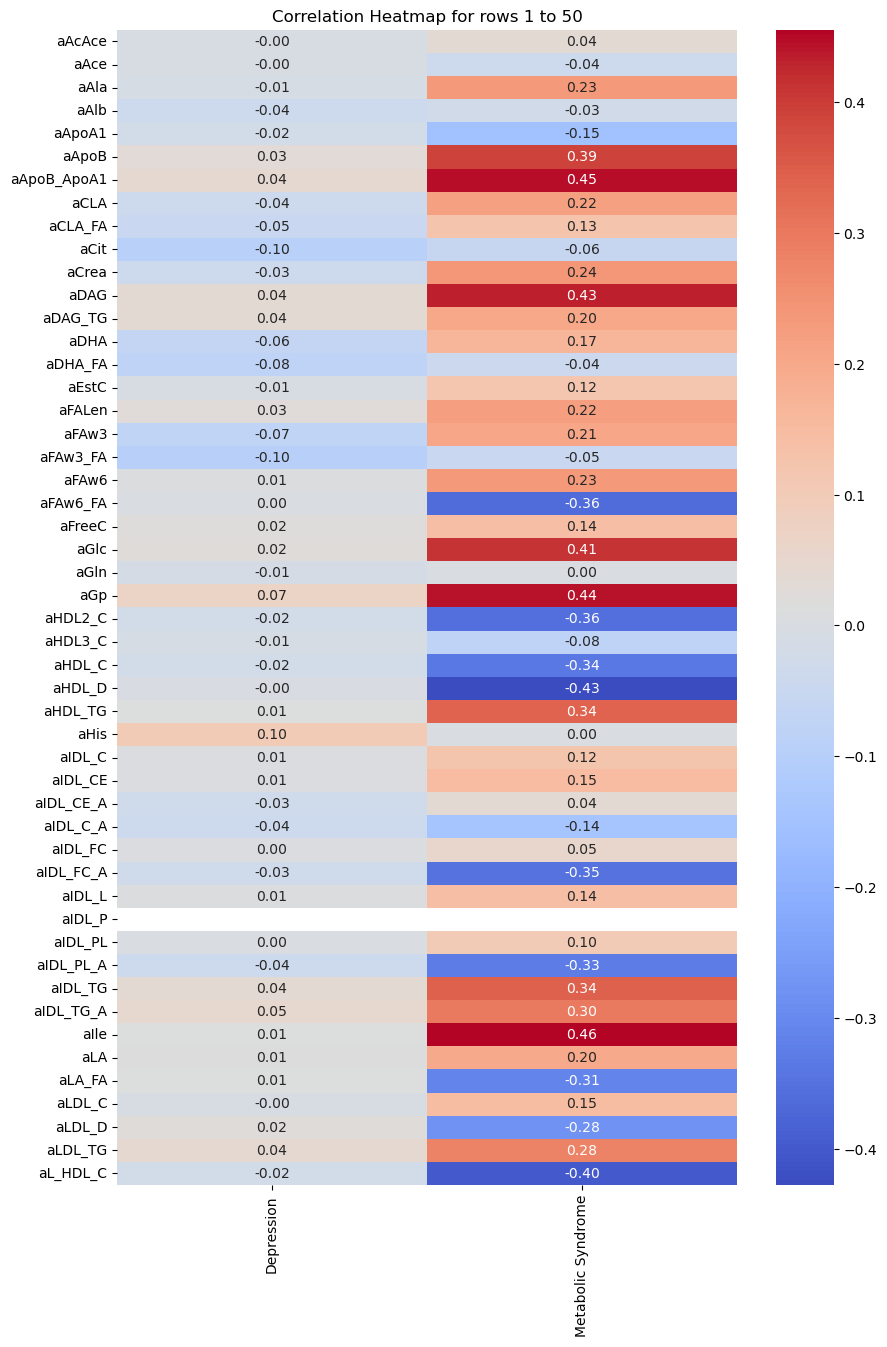

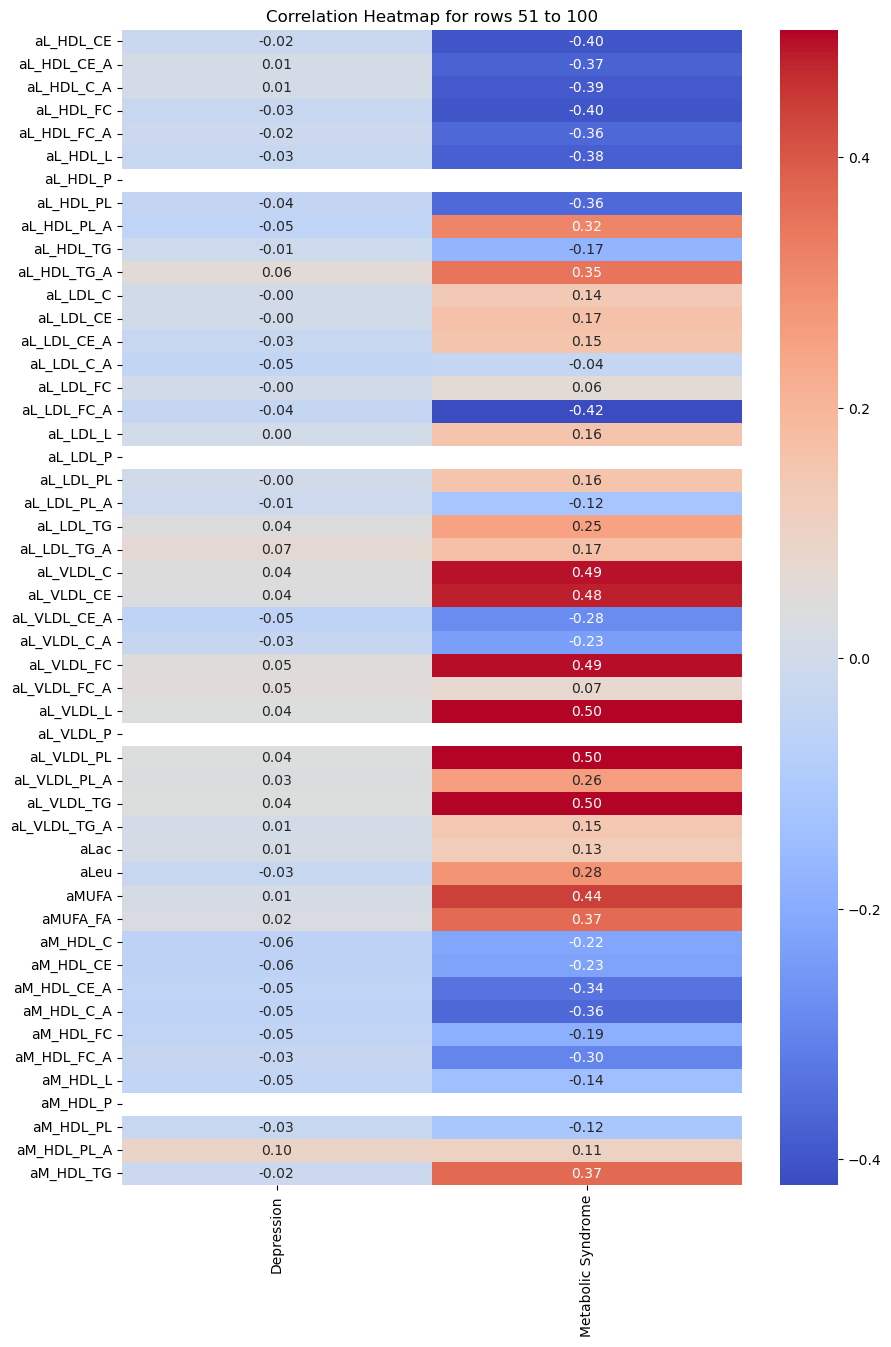

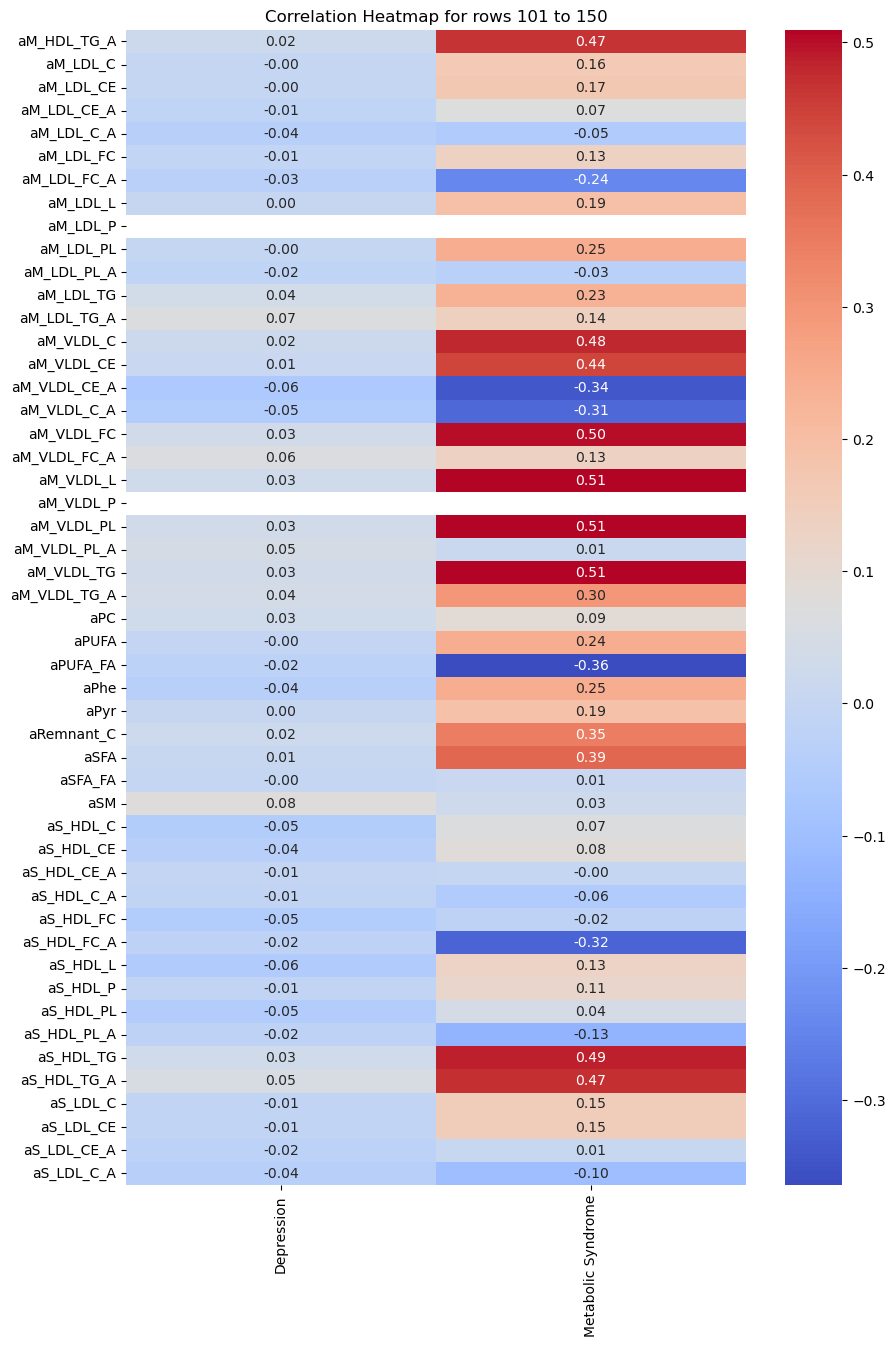

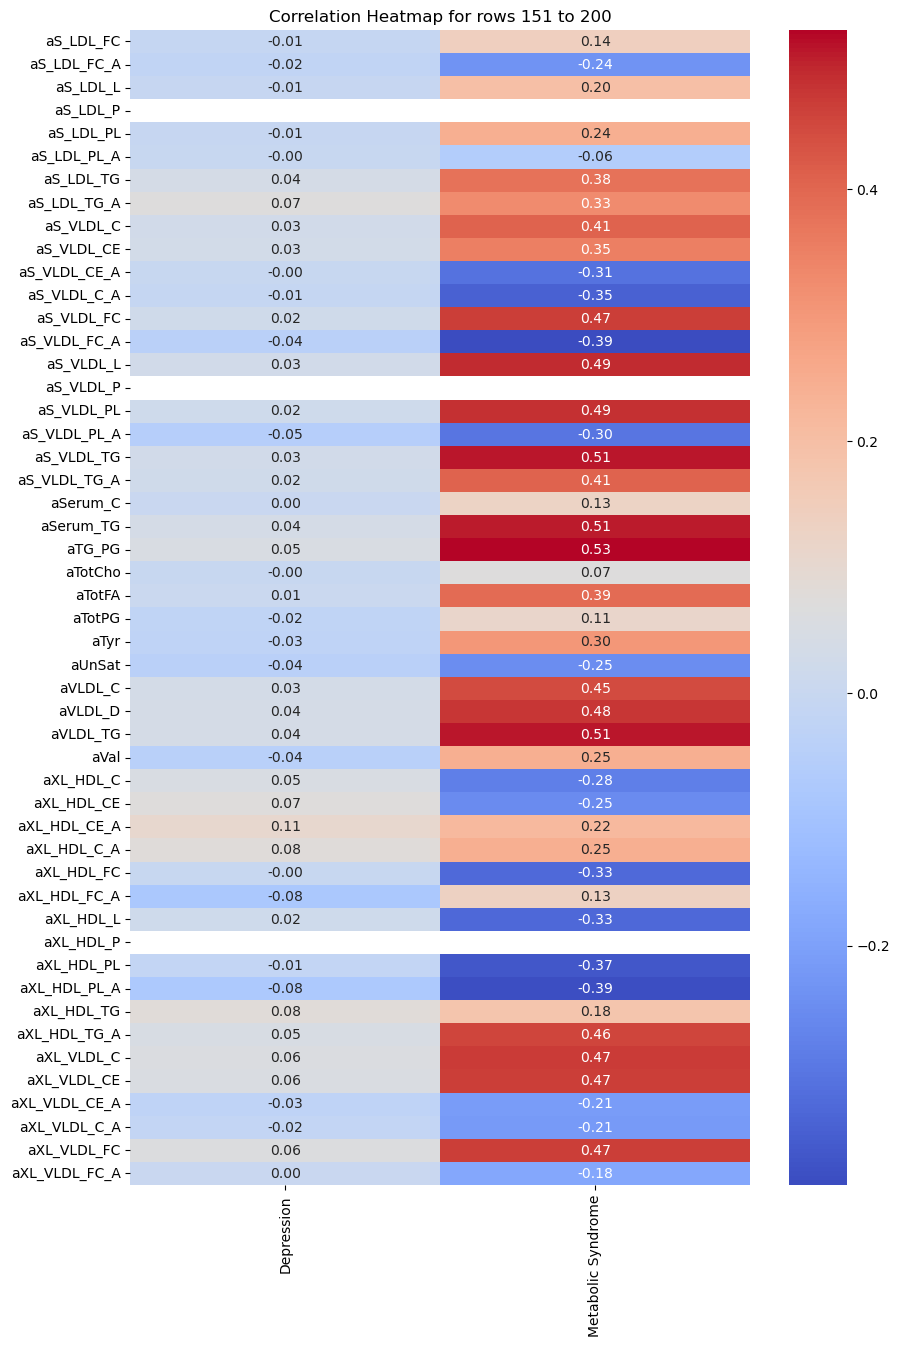

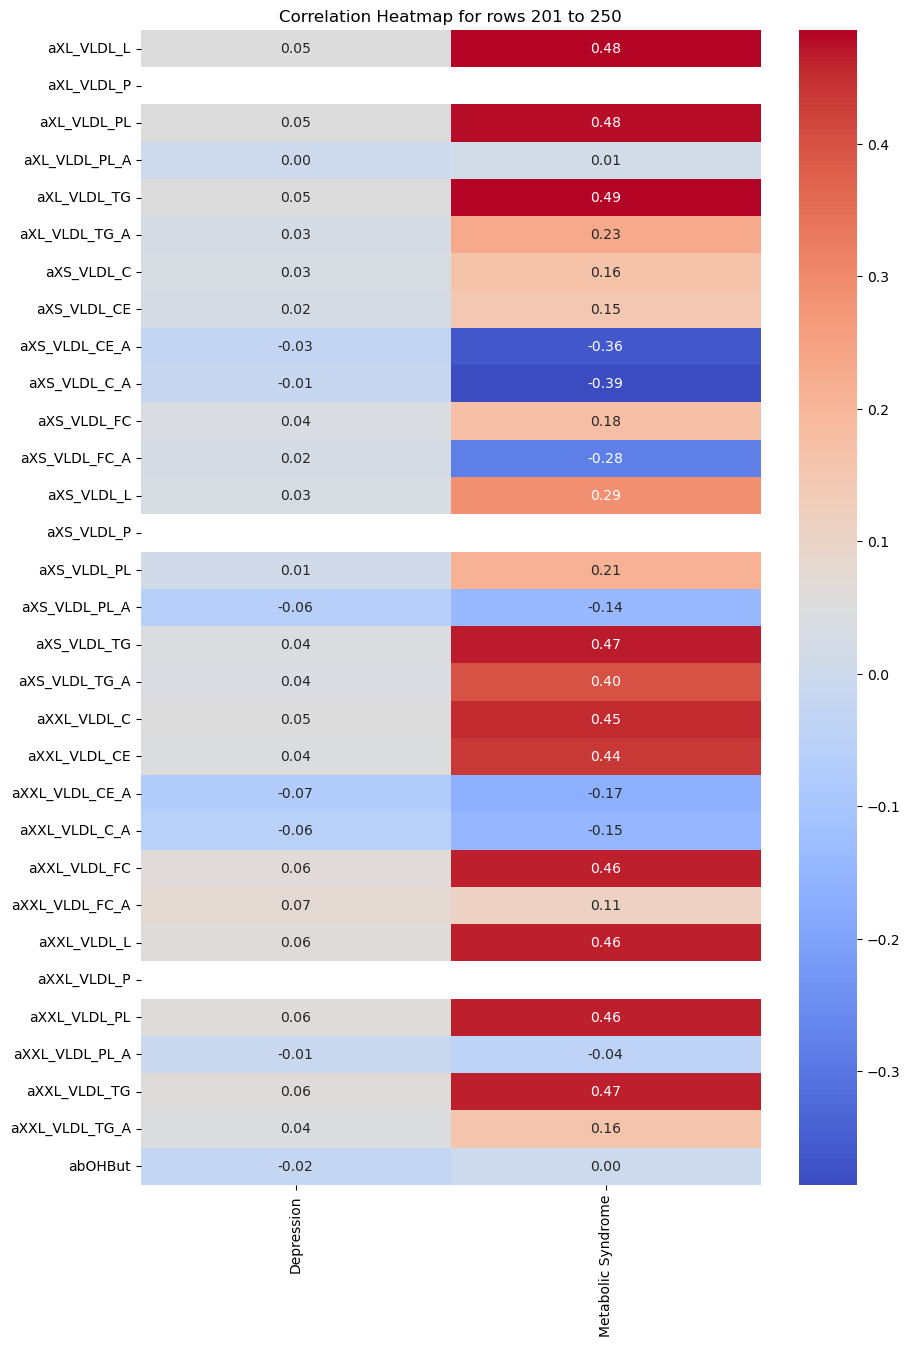

In [20]:
metabolite_features = data.columns.difference(non_metabolite_columns + ['acidep09', 'amet_syn2'])
X = data[metabolite_features]
y_depression = data['acidep09']
y_met_syndrome = data['amet_syn2']

correlation_with_depression = X.apply(lambda x: x.corr(y_depression))

correlation_with_met_syndrome = X.apply(lambda x: x.corr(y_met_syndrome))

correlations = pd.DataFrame({
    'Depression': correlation_with_depression,
    'Metabolic Syndrome': correlation_with_met_syndrome
})


rows_per_heatmap = 50
num_heatmaps = len(correlations) // rows_per_heatmap + (len(correlations) % rows_per_heatmap > 0)

for i in range(num_heatmaps):
    start_row = i * rows_per_heatmap
    end_row = start_row + rows_per_heatmap
    subset = correlations[start_row:end_row]
    
    plt.figure(figsize=(10, 15)) 
    heatmap = sns.heatmap(subset, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
    plt.title(f'Correlation Heatmap for rows {start_row+1} to {end_row}')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


In [21]:
sample_size = 231

def calculate_p_value(r, n=sample_size):
    if r == 1 or r == -1:
        return 0  # To handle perfect correlation edge case
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=n - 2))
    return p_value

# Apply the function across the data for each correlation
correlations['Depression_p_value'] = correlations['Depression'].apply(lambda r: calculate_p_value(r, sample_size))
correlations['Metabolic Syndrome_p_value'] = correlations['Metabolic Syndrome'].apply(lambda r: calculate_p_value(r, sample_size))

# Bonferroni correction
num_tests = len(correlations) * 2 
correlations['Depression_p_value_adj'] = correlations['Depression_p_value'] * num_tests
correlations['Metabolic Syndrome_p_value_adj'] = correlations['Metabolic Syndrome_p_value'] * num_tests

# Clipping adjusted p-values to 1 (maximum probability value)
correlations['Depression_p_value_adj'] = correlations['Depression_p_value_adj'].clip(upper=1)
correlations['Metabolic Syndrome_p_value_adj'] = correlations['Metabolic Syndrome_p_value_adj'].clip(upper=1)

# Determine thresholds
significance_level = 0.05
depression_threshold = correlations.loc[correlations['Depression_p_value_adj'] < significance_level, 'Depression'].abs().min()
metabolic_syndrome_threshold = correlations.loc[correlations['Metabolic Syndrome_p_value_adj'] < significance_level, 'Metabolic Syndrome'].abs().min()

print(f"Statistically justified threshold for Depression: {depression_threshold}")
print(f"Statistically justified threshold for Metabolic Syndrome: {metabolic_syndrome_threshold}")

Statistically justified threshold for Depression: nan
Statistically justified threshold for Metabolic Syndrome: 0.26314831941115124


In [24]:
metabolic_syndrome_threshold = 0.263

# Filter metabolites
strongly_correlated = correlations[
    (abs(correlations['Metabolic Syndrome']) >= metabolic_syndrome_threshold)
]

print("Selected Metabolites based on thresholds:")
len(strongly_correlated)

Selected Metabolites based on thresholds:


104

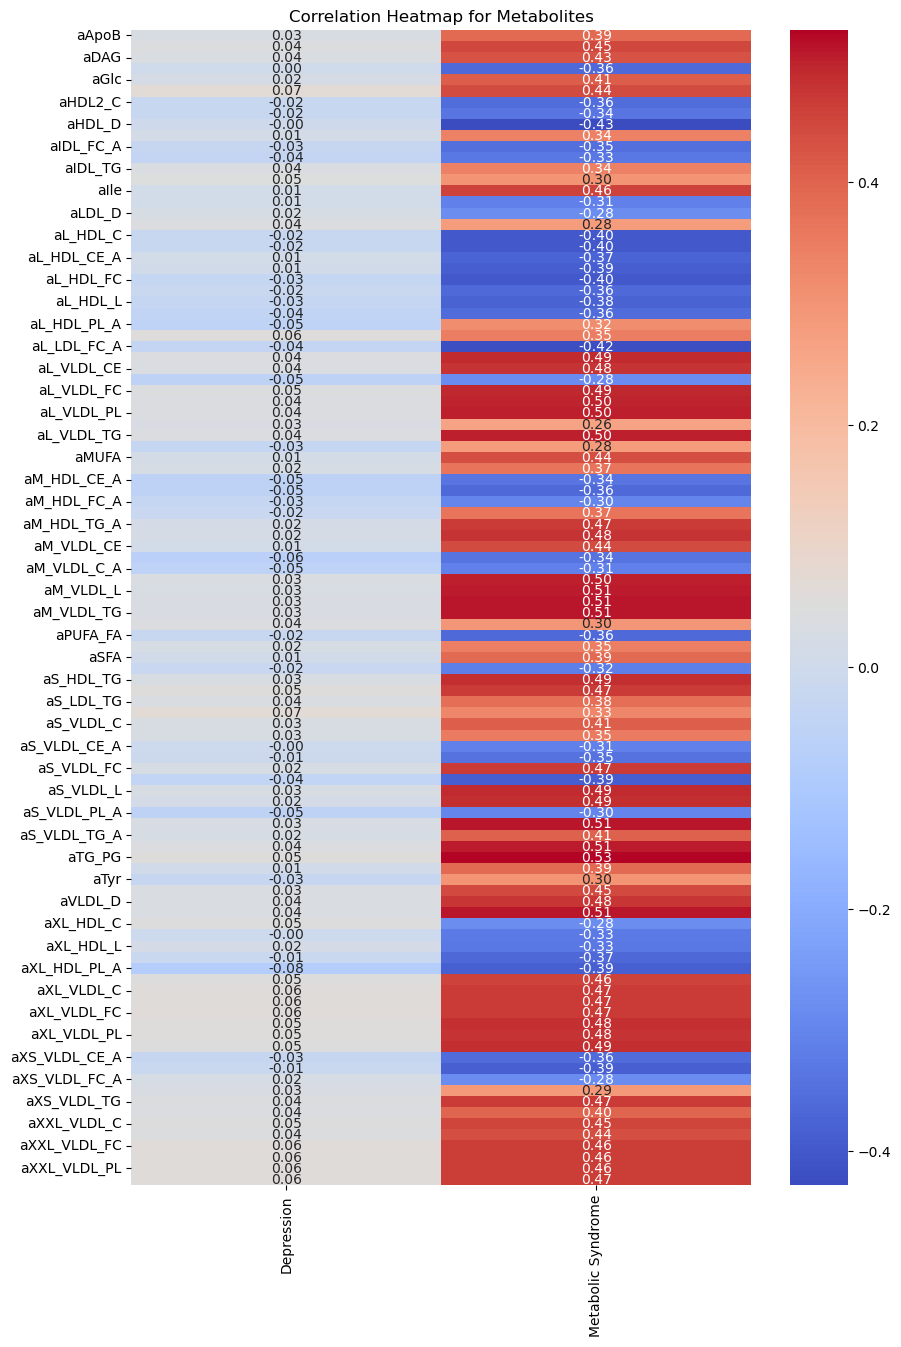

In [36]:
plt.figure(figsize=(10, 15)) 
heatmap = sns.heatmap(strongly_correlated.iloc[:, :2], annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title(f'Correlation Heatmap for Metabolites')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [26]:
# create a new csv file with the selected metabolites
selected_columns = list(strongly_correlated.index) + ['acidep09', 'amet_syn2']
final_data = data[selected_columns]
final_data.to_csv('../data/preprocessed/filtered_data_wave1.csv', index=False)

## XGBoost

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from xgboost import XGBClassifier
import joblib

In [29]:
data = pd.read_csv('../data/preprocessed/filtered_data_wave1.csv')

In [30]:
# replace -1 in amet_syn2 with NaN
data['amet_syn2'] = data['amet_syn2'].replace(-1, np.nan).astype(pd.Int64Dtype())
data = data.dropna(subset=['amet_syn2'])
data['amet_syn2'].value_counts()

0    2307
1     623
Name: amet_syn2, dtype: Int64

In [69]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

X = data.drop(['acidep09', 'amet_syn2'], axis=1) # features
y = data['acidep09']  # target

knn_imputer = KNNImputer(n_neighbors=10)
X = knn_imputer.fit_transform(X)
X = pd.DataFrame(X, columns=data.drop(['acidep09', 'amet_syn2'], axis=1).columns)

# Oversample the minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.1, random_state=42)

model = XGBClassifier(
    n_estimators=220,
    max_depth=3,
    learning_rate=0.1594177063297453,
    subsample=0.8738456216119495,
    colsample_bytree=0.9464212721711182,
    missing=np.nan,
    use_label_encoder=False,
    eval_metric='logloss'
)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')

print(f'Cross-validated Accuracy: {cv_accuracy.mean()}')
print(f'Cross-validated F1 Score: {cv_f1.mean()}')

# fit on the entire data
model.fit(X_train, y_train)

# evaluate on the validation set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(model, 'imputed_depression_model.pkl')

Cross-validated Accuracy: 0.659395866730964
Cross-validated F1 Score: 0.6590331405232001
Accuracy: 0.6851851851851852
F1 Score: 0.683000521200113

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       209
           1       0.66      0.60      0.63       169

    accuracy                           0.69       378
   macro avg       0.68      0.68      0.68       378
weighted avg       0.68      0.69      0.68       378



['imputed_depression_model.pkl']

In [56]:
X = data.drop(['acidep09', 'amet_syn2'], axis=1) # features
y = data['amet_syn2']  # target

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.5,
    missing=np.nan,
    use_label_encoder=False,
    eval_metric='logloss'
)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')

print(f'Cross-validated Accuracy: {cv_accuracy.mean()}')
print(f'Cross-validated F1 Score: {cv_f1.mean()}')

# fit on the entire data
model.fit(X_train, y_train)

# evaluate on the validation set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(model, 'met_syndrome_model.pkl')

Cross-validated Accuracy: 0.8703087128460261
Cross-validated F1 Score: 0.8669797707030735
Accuracy: 0.8856655290102389
F1 Score: 0.8862840037312013

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       480
         1.0       0.68      0.70      0.69       106

    accuracy                           0.89       586
   macro avg       0.81      0.81      0.81       586
weighted avg       0.89      0.89      0.89       586



['met_syndrome_model.pkl']

In [189]:
depression_model = joblib.load("models/imputed_depression_model.pkl")
met_syndrome_model = joblib.load("models/met_syndrome_model.pkl")

def get_feature_importance_based_on_weight(model):
    feature_importance = model.get_booster().get_score(importance_type='weight')
    importance = pd.Series(feature_importance).sort_values(ascending=False)
    return importance

def get_feature_importance_based_on_gain(model):
    feature_importance = model.feature_importances_
    feature_names = model.get_booster().feature_names
    importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)
    return importance

depression_importance = get_feature_importance_based_on_gain(depression_model)
met_syndrome_importance = get_feature_importance_based_on_gain(met_syndrome_model)

rank_depression = depression_importance.nlargest(40)
rank_met_syndrome = met_syndrome_importance.nlargest(40)

shared_metabolites = set(rank_depression.index) & set(rank_met_syndrome.index)
depression_only = set(rank_depression.index) - shared_metabolites
met_syndrome_only = set(rank_met_syndrome.index) - shared_metabolites


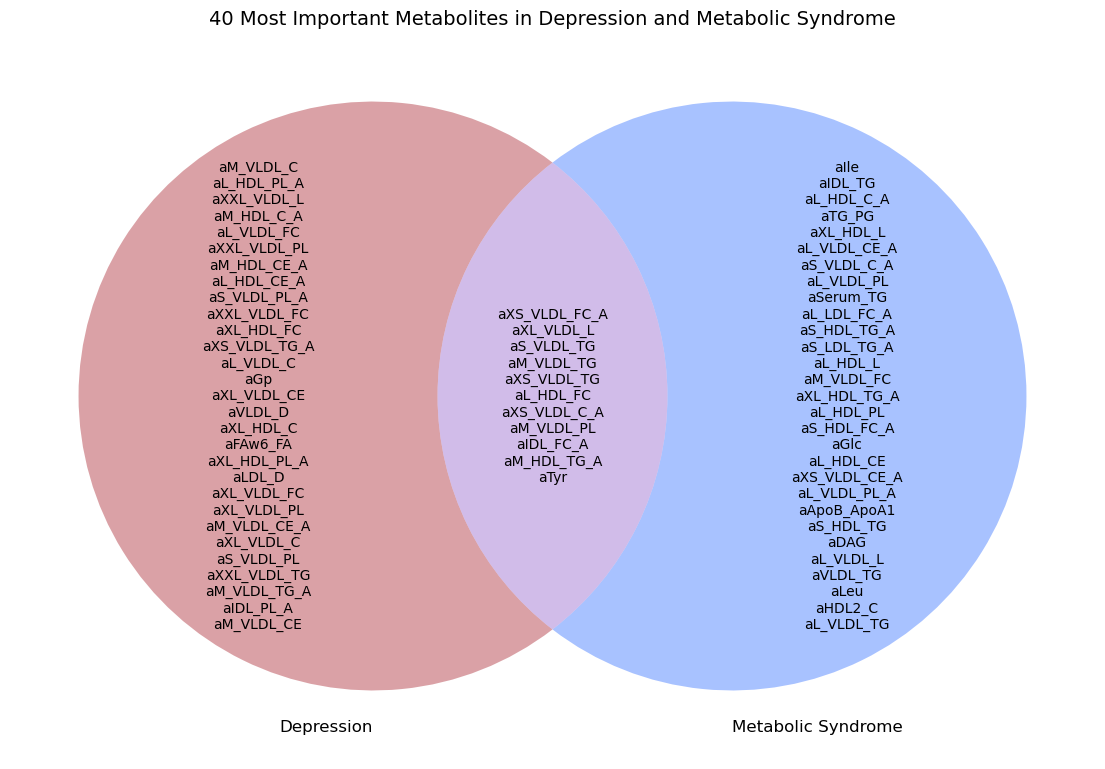

In [190]:
plt.figure(figsize=(14, 10))
venn = venn2([set(rank_depression.index), set(rank_met_syndrome.index)], ('Depression', 'Metabolic Syndrome'), set_colors=('#a31621', '#2667ff'))

def add_metabolites_to_venn(venn, metabolites, idx, offset):
    region = venn.get_label_by_id(idx)
    if region is not None:
        metabolites_str = "\n".join(metabolites)
        region.set_text(metabolites_str)
        region.set_position(np.array(region.get_position()) + np.array(offset))

add_metabolites_to_venn(venn, depression_only, '10', (0, 0))
add_metabolites_to_venn(venn, met_syndrome_only, '01', (0, 0))
add_metabolites_to_venn(venn, shared_metabolites, '11', (0, 0))

plt.title("40 Most Important Metabolites in Depression and Metabolic Syndrome", fontsize=14)
plt.show()

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_78285/306125183.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'Depression_Importance': depression_importance.loc[shared_metabolites],
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_78285/306125183.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  'Met_Syndrome_Importance': met_syndrome_importance.loc[shared_metabolites]


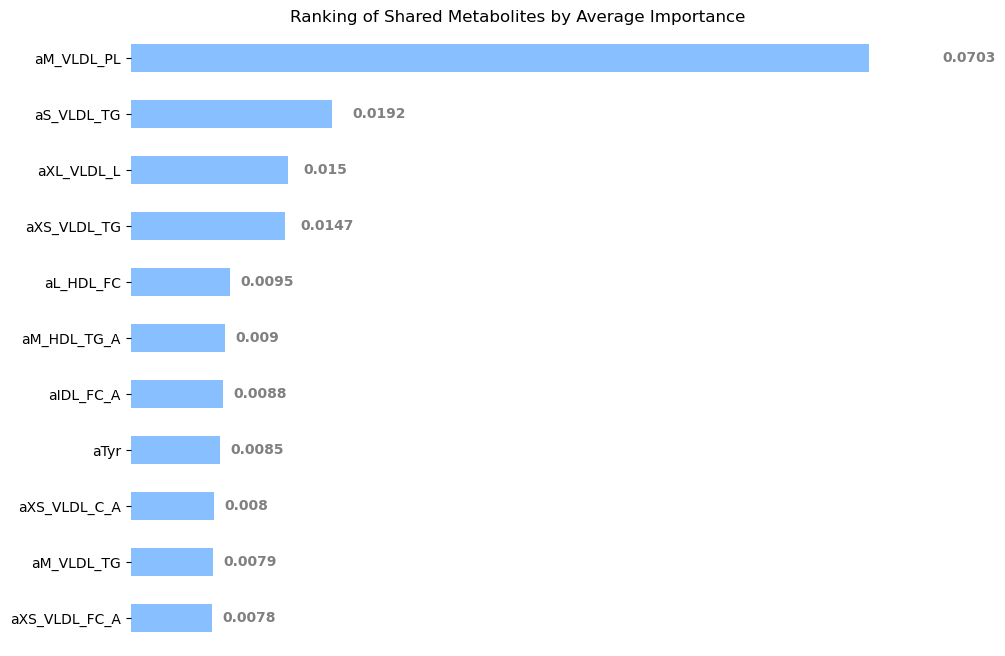

In [191]:
# Rank the shared metabolites by importance
shared_importance = pd.DataFrame({
    'Depression_Importance': depression_importance.loc[shared_metabolites],
    'Met_Syndrome_Importance': met_syndrome_importance.loc[shared_metabolites]
})
shared_importance['Importance'] = shared_importance.mean(axis=1)
ranked_shared_importance = shared_importance.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
ranked_shared_importance[['Importance']].plot(kind='barh', ax=ax, color='#87BFFF', legend=False)
ax.set_title('Ranking of Shared Metabolites by Average Importance')
ax.invert_yaxis()
ax.set_xticks([])  

# Add importance scores next to the bars
for i in ax.patches:
    ax.text(i.get_width() + max(0.001, i.get_width() * 0.1), i.get_y() + i.get_height() / 2,
            str(round(i.get_width(), 4)),
            fontsize=10, fontweight='bold',
            color='grey', verticalalignment='center')

# Remove box
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

In [192]:
ranked_shared_importance.index

Index(['aM_VLDL_PL', 'aS_VLDL_TG', 'aXL_VLDL_L', 'aXS_VLDL_TG', 'aL_HDL_FC',
       'aM_HDL_TG_A', 'aIDL_FC_A', 'aTyr', 'aXS_VLDL_C_A', 'aM_VLDL_TG',
       'aXS_VLDL_FC_A'],
      dtype='object')

In [188]:
shared_importance

,Depression_Importance,Met_Syndrome_Importance,Importance
eLHDLP,0.011863,0.014724,0.013293
eVLDLTG,0.010704,0.030386,0.020545
eXXLVLDLTG,0.012110,0.009429,0.010770
eXXLVLDLCE,0.018024,0.008498,0.013261
eTyr,0.009018,0.009651,0.009334
eLVLDLCE,0.012590,0.007030,0.009810
eSHDLTG,0.009339,0.013290,0.011315
eGlc,0.009612,0.029279,0.019446
eMHDLPL_A,0.010771,0.007409,0.009090
eXLVLDLCE,0.015130,0.008138,0.011634


### Test model performance with the shared metabolites as input features

In [119]:
selected = ['aM_VLDL_PL', 'aS_VLDL_TG', 'aXL_VLDL_L', 'aXS_VLDL_TG', 'aL_HDL_FC',
       'aM_HDL_TG_A', 'aIDL_FC_A', 'aTyr', 'aXS_VLDL_C_A', 'aM_VLDL_TG',
       'aXS_VLDL_FC_A']

X = data[selected] # features
y = data['amet_syn2']  # target


# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=0.5,
    missing=np.nan,
    use_label_encoder=False,
    eval_metric='logloss'
)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')

print(f'Cross-validated Accuracy: {cv_accuracy.mean()}')
print(f'Cross-validated F1 Score: {cv_f1.mean()}')

# fit on the entire data
model.fit(X_train, y_train)

# evaluate on the validation set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Cross-validated Accuracy: 0.8536766715871194
Cross-validated F1 Score: 0.8481678170439336
Accuracy: 0.8720136518771331
F1 Score: 0.8712944452524656

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       480
         1.0       0.65      0.63      0.64       106

    accuracy                           0.87       586
   macro avg       0.78      0.78      0.78       586
weighted avg       0.87      0.87      0.87       586



## Shared Metabolites

In [3]:
column_mapping = {
    'eTyr': 'aTyr',
    'eVLDLTG': 'aVLDL_TG',
    'eGlc': 'aGlc',
    'eLHDLP': 'aL_HDL_P',
    'eXXLVLDLCE': 'aXXL_VLDL_CE',
    'eXLVLDLTG': 'aXL_VLDL_TG',
    'eXXLVLDLTG': 'aXXL_VLDL_TG',
    'eXLVLDLCE': 'aXL_VLDL_CE',
    'eSHDLTG': 'aS_HDL_TG',
    'eLVLDLCE': 'aL_VLDL_CE',
    'eMHDLPL_A': 'aM_HDL_PL_A',
    'eMVLDLPL': 'aM_VLDL_PL',
    'eSVLDLTG': 'aS_VLDL_TG',
    'eXLVLDLL': 'aXL_VLDL_L',
    'eXSVLDLTG': 'aXS_VLDL_TG',
    'eLHDLFC': 'aL_HDL_FC',
    'eMHDLTG_A': 'aM_HDL_TG_A',
    'eIDLFC_A': 'aIDL_FC_A',
    'eXSVLDLC_A': 'aXS_VLDL_C_A',
    'eMVLDLTG': 'aM_VLDL_TG',
    'eXSVLDLFC_A': 'aXS_VLDL_FC_A'
}


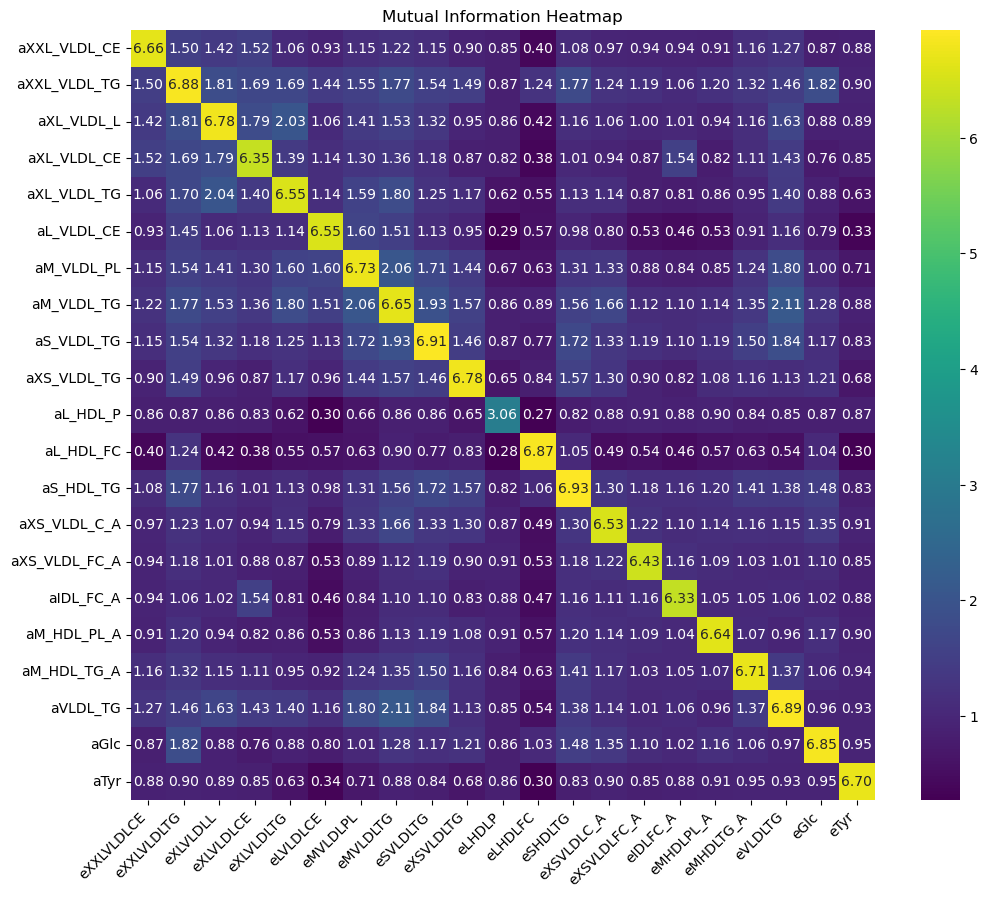

In [4]:
DataAnalysis.plot_mutual_information_heatmap('../data/data_wave1.csv', '../data/data_wave5.csv', column_mapping)

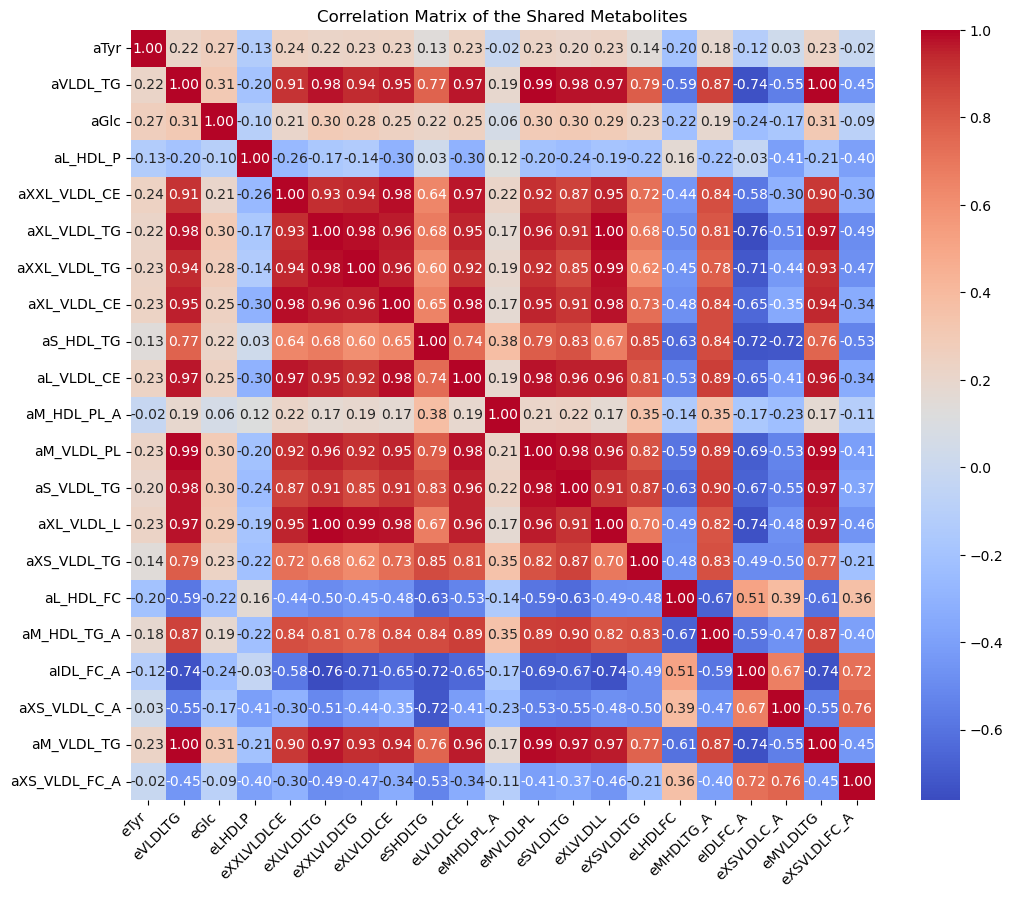

In [4]:
DataAnalysis.plot_correlation_matrix_two_df('../data/data_wave1.csv', '../data/data_wave5.csv', column_mapping)